In [31]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

import os
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score

In [32]:
current_path = os.getcwd()

print(current_path)

c:\Users\decem\Desktop\Exercise Files


Text(0.5, 1.0, 'jackhammer')

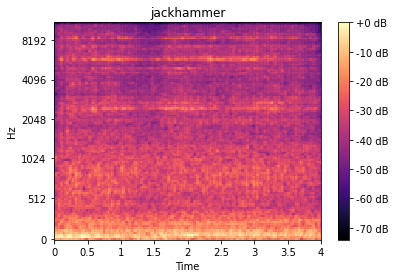

In [33]:
df = pd.read_csv("SD_Project/UrbanSound8K/metadata/UrbanSound8K.csv")
data_size = len(df)
fold_number = np.random.choice(data_size)
file_name = 'SD_Project/Urbansound8k/audio/fold' + str(df["fold"][fold_number]) + '/' + df["slice_file_name"][fold_number]


x, sr = librosa.load(file_name)
n_fft = 2048

# spec = np.abs(librosa.stft(y=x))
# spec = librosa.amplitude_to_db(spec, ref = np.max)

mel_spec = librosa.feature.melspectrogram(y=x, sr=sr, n_fft= n_fft)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(mel_spec, sr = sr, x_axis = "time", y_axis= "mel")
plt.colorbar(format = "%+2.0f dB")
plt.title(df["class"][fold_number])


In [42]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(data_size):
        file_name = 'SD_Project/Urbansound8k/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

temp = parser(df)
temp = np.array(temp)
data = temp.transpose()
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([data_size, 128])

# for unknown label 10= unknown

for i in range(data_size):
    X[i] = (X_[i])

Y = to_categorical(Y)

test_size = 0.1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,random_state = 1,test_size = test_size)
X_total,Y_total = shuffle(X, Y)
X_total = X_total.reshape(data_size,16,8,1)
X_train = X_train.reshape(round((data_size)*(1-test_size)),16,8,1)
X_test = X_test.reshape(round((data_size)*test_size),16,8,1)
input_dim = (16,8,1)
# input_dim is fixed to 128 as we use melspectrogram from librosa -> 16*8*1 = 128


c:\Users\decem\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:2538: UserWarning: n_fft=2048 is too small for input signal of length=1323
  stft(
c:\Users\decem\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:2538: UserWarning: n_fft=2048 is too small for input signal of length=1103
  stft(
c:\Users\decem\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:2538: UserWarning: n_fft=2048 is too small for input signal of length=1523
  stft(


(8732,) (8732,)


C:\Users\decem\AppData\Local\Temp/ipykernel_23432/1389847888.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(temp)


In [47]:
input_dim = (16,8,1)
model = Sequential()

model.add(Conv2D(32, (2,2), strides=1, padding = "same", activation = "relu", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2), strides=1))
model.add(Conv2D(128, (2,2), strides=1, padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size=(2, 2),strides=1))
# model.add(Dropout(0.8))
model.add(Flatten())
# model.add(Dense(1024, activation = "relu"))
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

Optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = Optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train,Y_train, validation_split=0.1, epochs=50, batch_size=8)

Epoch 1/50
835/835 [==============================] - 9s 8ms/step - loss: 1.6116 - accuracy: 0.4742 - val_loss: 1.3040 - val_accuracy: 0.5895
Epoch 2/50
835/835 [==============================] - 6s 7ms/step - loss: 1.1147 - accuracy: 0.6315 - val_loss: 1.2467 - val_accuracy: 0.6312
Epoch 3/50
835/835 [==============================] - 5s 6ms/step - loss: 0.9311 - accuracy: 0.6947 - val_loss: 1.0718 - val_accuracy: 0.6581
Epoch 4/50
835/835 [==============================] - 6s 7ms/step - loss: 0.7660 - accuracy: 0.7447 - val_loss: 0.9962 - val_accuracy: 0.7079
Epoch 5/50
835/835 [==============================] - 5s 6ms/step - loss: 0.6727 - accuracy: 0.7748 - val_loss: 0.9315 - val_accuracy: 0.7174
Epoch 6/50
835/835 [==============================] - 6s 7ms/step - loss: 0.5889 - accuracy: 0.8028 - val_loss: 0.8596 - val_accuracy: 0.7699
Epoch 7/50
835/835 [==============================] - 6s 7ms/step - loss: 0.5019 - accuracy: 0.8361 - val_loss: 0.8363 - val_accuracy: 0.7550
Epoch 

In [52]:
predictions = model.predict(X_test, batch_size = 30)
score = model.evaluate(X_test, Y_test)
pred_y = np.argmax(predictions, axis = -1)
round_y = np.argmax(Y_test, axis = -1)

41/41 [==============================] - 1s 2ms/step - loss: 1.2438 - accuracy: 0.8076


In [53]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[143   0   3   0   0   1   0   0   0   3]
 [  0  53   1   2   4   1   0   0   0   8]
 [  3   0  94  12   2   2   0   3   5  26]
 [  2   2  12 101   2   2   0   1  13  12]
 [  1   1   6   7 111   0   1  11   1   8]
 [  2   0   7   0   2 135   0   0   1   3]
 [  0   0   2   0   4   0  47   2   0   1]
 [  3   0   1   2   9   1   0 155   0   2]
 [  0   0   1   9   0   0   0   1 120   4]
 [  7   0  10   4   6   2   0   5   3  99]]


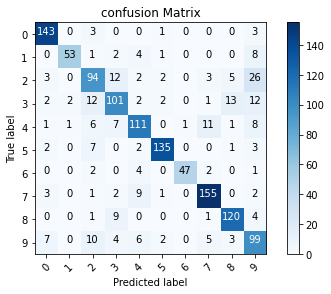

In [55]:
cm_plot_labels = [0,1,2,3,4,5,6,7,8,9]
conf_mat = confusion_matrix(y_true = round_y , y_pred= pred_y, labels=cm_plot_labels)
plot_confusion_matrix(cm=conf_mat, classes=cm_plot_labels, title='confusion Matrix')